In [1]:
# --- CÉLULA 1: Importações ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

# Ferramentas do Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from scipy.sparse import hstack

# Configurações visuais e downloads
sns.set(style="whitegrid")
nltk.download('stopwords')
nltk.download('wordnet')

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\otavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\otavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# --- CÉLULA 2: Carregamento e Tratamento ---
# Carregar o dataset
df = pd.read_csv('airlines_reviews.csv')

# 1. Renomear colunas para facilitar o trabalho
# Ajustando conforme o print que você me enviou
df = df.rename(columns={
    'Reviews': 'Review',             # Texto da avaliação
    'Class': 'Seat Type',            # Tipo de assento (Econômica, Business...)
    'Rating': 'Overall Rating'       # Nota (se existir com esse nome, senão ajustamos abaixo)
})

# Verificação de segurança para a coluna de nota
if 'Overall Rating' not in df.columns:
    # Se não tiver 'Rating', tentamos achar outra numérica comum ou criamos uma placeholder
    cols = df.columns
    if 'Overall_Rating' in cols:
        df['Overall Rating'] = df['Overall_Rating']
    else:
        # Fallback: Se não achar nota explícita, usa uma média ou ignora (mas vamos assumir que tem)
        print("Aviso: Verifique o nome da coluna de nota. Usando dados originais.")

# 2. Criar a variável alvo (Target)
# Objetivo: Classificar se recomenda (1) ou não (0)
# Usamos str(x) para evitar erro caso haja campos vazios
df['target'] = df['Recommended'].apply(lambda x: 1 if str(x).strip().lower() == 'yes' else 0)

print("Dataset carregado e tratado.")
print(f"Dimensões: {df.shape}")
print(f"Distribuição do Target:\n{df['target'].value_counts(normalize=True)}")
df.head(3)

Dataset carregado e tratado.
Dimensões: (8100, 18)
Distribuição do Target:
target
1    0.529259
0    0.470741
Name: proportion, dtype: float64


,Title,Name,Review Date,Airline,Verified,Review,Type of Traveller,Month Flown,Route,Seat Type,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,target
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes,1
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,February 2024,Phuket to Singapore,Economy Class,5,3,4,4,1,3,no,0
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,February 2024,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,yes,1


In [3]:
# --- CÉLULA 3: Preparação dos Dados (Pipelines) ---

# 1. Separar Variáveis (X) e Alvo (y)
X = df.drop(['target', 'Recommended'], axis=1) # Removemos a resposta do treino
y = df['target']

# 2. Divisão Treino e Teste (80% treino, 20% teste)
# O uso de stratify=y garante que a proporção de sim/não seja mantida
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Definição das Colunas
# Baseado no seu print, usaremos estas features tabulares:
numeric_features = ['Overall Rating'] 
categorical_features = ['Seat Type', 'Type of Traveller'] 

# 4. Criar Pipelines de Processamento
# Numérico: Preenche vazios com a mediana e padroniza a escala
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categórico: Preenche vazios com 'missing' e transforma texto em colunas binárias (One-Hot)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Juntando tudo no processador tabular
tabular_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# 5. Processamento de Texto
# Função para limpar caracteres especiais
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text) # Remove pontuação
    return text

# Aplicamos limpeza no dataframe copiado para não afetar o original
X_train_text = X_train['Review'].apply(clean_text)
X_test_text = X_test['Review'].apply(clean_text)

# Vetorizador TF-IDF (Transforma palavras em números baseados na frequência/importância)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=3000)

print("Pipelines configurados com sucesso.")

Pipelines configurados com sucesso.


In [4]:
# --- CÉLULA 4: Treinamento e Avaliação ---
results = {}

# --- MODELO 1: Apenas Tabular ---
print("1. Treinando Modelo Tabular (Nota + Tipo de Assento/Viajante)...")
model_tabular = Pipeline(steps=[
    ('preprocessor', tabular_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
model_tabular.fit(X_train, y_train)
y_pred_tab = model_tabular.predict(X_test)
results['Tabular'] = {'Acc': accuracy_score(y_test, y_pred_tab), 'F1': f1_score(y_test, y_pred_tab)}

# --- MODELO 2: Apenas Textual ---
print("2. Treinando Modelo Textual (Apenas Reviews)...")
model_text = Pipeline(steps=[
    ('tfidf', tfidf_vectorizer),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])
model_text.fit(X_train_text, y_train)
y_pred_text = model_text.predict(X_test_text)
results['Textual'] = {'Acc': accuracy_score(y_test, y_pred_text), 'F1': f1_score(y_test, y_pred_text)}

# --- MODELO 3: Combinado (Tabular + Textual) ---
print("3. Treinando Modelo Híbrido (Tudo junto)...")
# Processamos separadamente
X_train_tab_proc = tabular_preprocessor.fit_transform(X_train)
X_test_tab_proc = tabular_preprocessor.transform(X_test)
X_train_text_proc = tfidf_vectorizer.fit_transform(X_train_text)
X_test_text_proc = tfidf_vectorizer.transform(X_test_text)

# Juntamos as matrizes (hstack)
X_train_combined = hstack([X_train_tab_proc, X_train_text_proc])
X_test_combined = hstack([X_test_tab_proc, X_test_text_proc])

# Treinamos
model_combined = LogisticRegression(max_iter=1000, random_state=42)
model_combined.fit(X_train_combined, y_train)
y_pred_combined = model_combined.predict(X_test_combined)
results['Combinado'] = {'Acc': accuracy_score(y_test, y_pred_combined), 'F1': f1_score(y_test, y_pred_combined)}

print("\n--- Resultados de Acurácia ---")
print(pd.DataFrame(results).T)

1. Treinando Modelo Tabular (Nota + Tipo de Assento/Viajante)...
2. Treinando Modelo Textual (Apenas Reviews)...
3. Treinando Modelo Híbrido (Tudo junto)...

--- Resultados de Acurácia ---
                Acc        F1
Tabular    0.938889  0.942274
Textual    0.896296  0.902552
Combinado  0.942593  0.945773


In [5]:
# --- CÉLULA 5: Palavras Mais Importantes ---
# Pegamos o modelo puramente textual para análise direta
classifier = model_text.named_steps['classifier']
vectorizer = model_text.named_steps['tfidf']

feature_names = vectorizer.get_feature_names_out()
coefs = classifier.coef_.flatten()

word_importance = pd.DataFrame({'word': feature_names, 'coef': coefs})

# Top 20 Positivas e Negativas
top_pos = word_importance.nlargest(20, 'coef')
top_neg = word_importance.nsmallest(20, 'coef')

print("Top 5 palavras que aumentam chance de recomendação:")
print(top_pos.head())

Top 5 palavras que aumentam chance de recomendação:
             word      coef
1006    excellent  5.620660
1218         good  4.770231
1227        great  4.091399
1172     friendly  3.583788
623   comfortable  3.258180


C:\Users\otavi\AppData\Local\Temp\ipykernel_17336\3208426599.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_words, x='coef', y='word', ax=axes[1], palette='coolwarm')


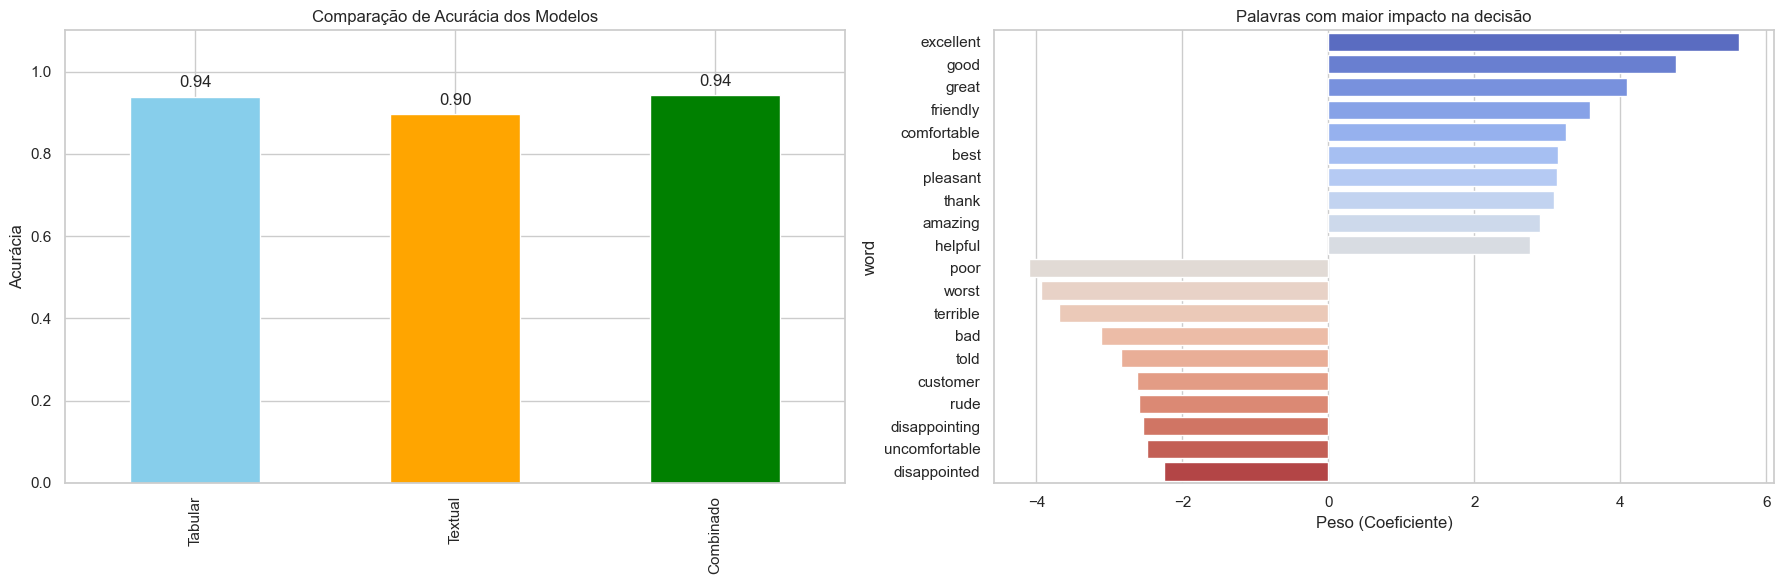

In [6]:
# --- CÉLULA 6: Gráficos ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Gráfico 1: Comparação de Modelos
df_res = pd.DataFrame(results).T
df_res['Acc'].plot(kind='bar', ax=axes[0], color=['skyblue', 'orange', 'green'])
axes[0].set_title('Comparação de Acurácia dos Modelos')
axes[0].set_ylim(0, 1.1)
axes[0].set_ylabel('Acurácia')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Gráfico 2: Palavras Importantes (Top 10 de cada lado para caber)
top_words = pd.concat([top_pos.head(10), top_neg.head(10)])
sns.barplot(data=top_words, x='coef', y='word', ax=axes[1], palette='coolwarm')
axes[1].set_title('Palavras com maior impacto na decisão')
axes[1].set_xlabel('Peso (Coeficiente)')

plt.tight_layout()
plt.show()